<a href="https://colab.research.google.com/github/yomyaykya/yomyay/blob/master/WaiPhyoThuHUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

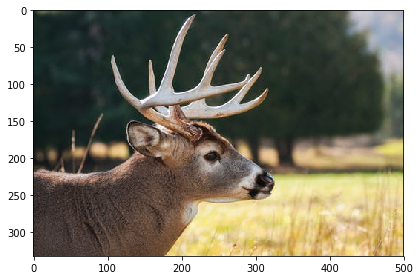

In [ ]:
%matplotlib inline

import numpy as np
import skimage.io as io
import pylab
import matplotlib.pyplot as plt

deer_img = io.imread('/content/deer.jpeg') 
io.imshow(deer_img)
io.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
## Let's convert the picture into string representation
# using the ndarray.tostring() function 
smile_string = smile_img.tostring()

# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_smile_1d = np.fromstring(smile_string, dtype=np.uint8)

# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_smile_img = reconstructed_smile_1d.reshape(smile_img.shape)

# Let's check if we got everything right and compare
# reconstructed array to the original one.
np.allclose(smile_img, reconstructed_smile_img)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


True

In [ ]:
# Get some image/annotation pairs for example 
filename_pairs = [
('/content/2007_000032.jpg',
'/content/2007_000032.png'),
('/content/2007_000039.jpg',
'/content/2007_000039.png'),
('/content/2007_000063.jpg',
'/content/2007_000063.png')
                 ]

In [ ]:
%matplotlib inline

# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

writer = tf.io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, annotation_path in filename_pairs:
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

In [ ]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))
    

In [ ]:
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))


True
True
True
True
True
True


In [ ]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

tfrecords_filename = 'pascal_voc_segmentation.tfrecords'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.pack([height, width, 3])
    annotation_shape = tf.pack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, annotations

(384, 384, 3)
current batch


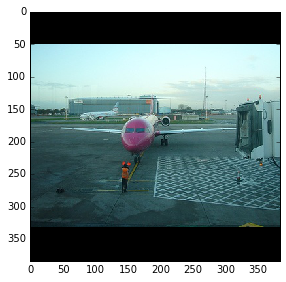

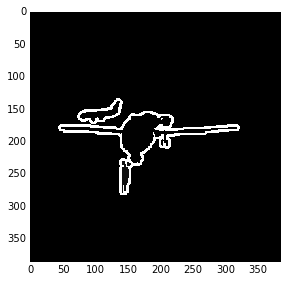

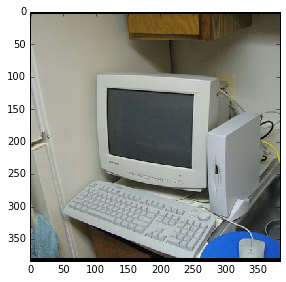

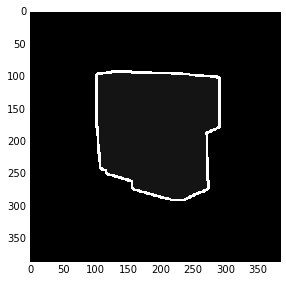

(384, 384, 3)
current batch


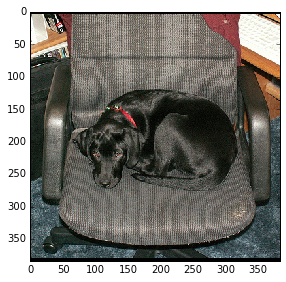

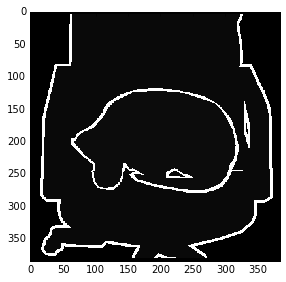

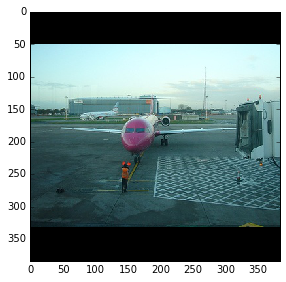

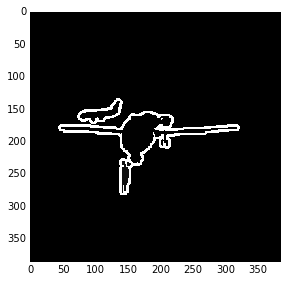

(384, 384, 3)
current batch


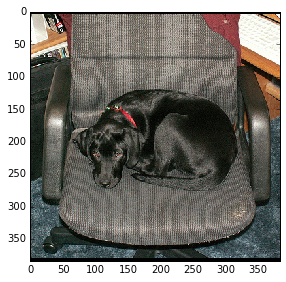

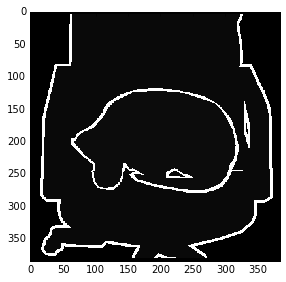

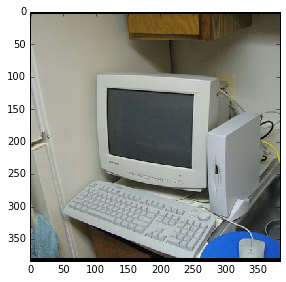

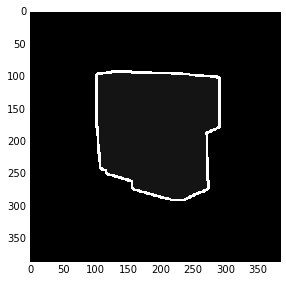

In [ ]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        io.imshow(img[1, :, :, :])
        io.show()

        io.imshow(anno[1, :, :, 0])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)
